In [1]:
import sys

%load_ext autoreload
# %load_ext line_profiler
%autoreload 2


sys.path.append("..")

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import scienceplots
from joblib import Parallel, delayed
from matplotlib import rc
from tqdm.notebook import tqdm
from typing import List, Optional, Sequence, Tuple, Union
import pprint


from zfista import minimize_proximal_gradient
# from zfista.problems import FDS, JOS1,  SD #FDS_CONSTRAINED,JOS1_L1,
from zfista.problems import FDS, JOS1, SD, Problem, TRIDIA, ZDT1 #FDS_CONSTRAINED, JOS1_L1,

In [3]:
fig_path = os.path.abspath(os.path.join("./figs"))
data_path = os.path.abspath(os.path.join("./data"))
os.makedirs(fig_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
# rc("text", usetex=True)
# plt.style.use(["science", "bright"])

In [4]:
def generate_start_points(low, high, n_features, n_samples=1000):
    return [
        np.random.uniform(low=low, high=high, size=n_features) for _ in range(n_samples)
    ]


def run(
    problem,
    start_points,
    tol=1e-5,
    nesterov=False,
    nesterov_ratio=(0, 0.25),
    n_jobs=-1,
    verbose=False,
    inertial=False,
    inertial_params=(0, 0)
):
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(problem.minimize_proximal_gradient)(
            x0,
            tol=tol,
            nesterov=nesterov,
            nesterov_ratio=nesterov_ratio,
            return_all=True,
            verbose=verbose,
            inertial=inertial,
            inertial_params=inertial_params
        )
        for x0 in start_points
    )
    # results = [
    #     problem.minimize_proximal_gradient(
    #         x0,
    #         tol=tol,
    #         nesterov=nesterov,
    #         nesterov_ratio=nesterov_ratio,
    #         return_all=True,
    #         verbose=verbose,
    #         inertial=inertial,
    #         inertial_params=inertial_params
    #     )
    #     for x0 in start_points
    # ]
    return results


def show_Pareto_front(
    problem,
    results,
    results_nesterov,
    step=None,
    s=15,
    alpha=0.75,
    fname=None,
    elev=15,
    azim=130,
    linewidths=0.1,
):
    labels = [
        "Starting points",
        f"PGM ($k={step}$)",
        f"Acc-PGM ($k={step}$)",
        "PGM (Solutions)",
        "Acc-PGM (Solutions)",
    ]
    fig = plt.figure(figsize=(7.5, 7.5), dpi=100)
    if problem.n_objectives == 2:
        ax = fig.add_subplot(111)
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    if problem.n_objectives == 3:
        ax = fig.add_subplot(111, projection="3d", clip_on=True)
        ax.view_init(elev=elev, azim=azim)
        fig.subplots_adjust(left=0, right=1, bottom=0, top=0.6)
    for i, (result, result_acc) in tqdm(enumerate(zip(results, results_nesterov))):        
        allvecs = result.allvecs
        allvecs_acc = result_acc.allvecs
        x0 = allvecs[0]
        F_of_x0 = problem.f(x0) + problem.g(x0)
        if step is not None:
            xk = allvecs[step]
            xk_acc = allvecs_acc[step]
            F_of_xk = problem.f(xk) + problem.g(xk)
            F_of_xk_acc = problem.f(xk_acc) + problem.g(xk_acc)
        F_pareto = result.fun
        F_pareto_acc = result_acc.fun
        if problem.n_objectives == 2:
            ax.scatter(
                *F_of_x0,
                color="#8e44ad",
                marker="x",
                label=labels[0],
                s=s,
                alpha=alpha,
                linewidths=linewidths,
            )
            if step is not None:
                ax.scatter(
                    *F_of_xk,
                    color="#2980b9",
                    marker="<",
                    label=labels[1],
                    s=s,
                    alpha=alpha,
                    linewidths=linewidths,
                )
                ax.scatter(
                    *F_of_xk_acc,
                    facecolors="none",
                    edgecolor="#e74c3c",
                    marker="*",
                    label=labels[2],
                    s=s,
                    alpha=alpha,
                    linewidths=linewidths,
                )
        ax.scatter(
            *F_pareto,
            color="#2980b9",
            marker=".",
            label=labels[3],
            s=s,
            alpha=alpha,
            linewidths=linewidths,
        )
        ax.scatter(
            *F_pareto_acc,
            facecolors="none",
            edgecolors="#e74c3c",
            marker="D",
            label=labels[4],
            s=s,
            alpha=alpha,
            linewidths=linewidths,
        )
    ax.set_xlabel(r"$F_1$", fontsize=15)
    ax.set_ylabel(r"$F_2$", fontsize=15)
    if problem.n_objectives == 3:
        ax.set_zlabel(r"$F_3$", fontsize=15)
        ax.legend(labels[-2:], bbox_transform=ax.transData)
    elif step is None:
        ax.legend([labels[0]] + labels[-2:])
    else:
        ax.legend(labels)
    if fname is not None:
        plt.savefig(fig_path + "/" + fname, bbox_inches="tight")


def get_stats(results):
    nits = [result.nit for result in results]
    nit_internals = [result.nit_internal for result in results]
    # execution_times = [result.execution_time for result in results]
    stats = {
        "nit": {"mean": np.mean(nits), "std": np.std(nits), "max": np.max(nits)},
        "nit_internal": {
            "mean": np.mean(nit_internals),
            "std": np.std(nit_internals),
            "max": np.max(nit_internals),
        },
        # "execusion_time": {
        #     "mean": np.mean(execution_times),
        #     "std": np.std(execution_times),
        #     "max": np.max(execution_times),
        # },
    }
    return stats

## JOS1
Minimize
$$
f_1(x) = \frac{1}{n} \| x \|_2^2, \quad f_2(x) = \frac{1}{n} \| x - 2\|_2^2
$$
subject to $x \in \mathbf{R^n}$.

In [5]:
n_features = 50
n_samples = 200
problem_JOS1 = JOS1(n_features=n_features)
start_points_JOS1 = generate_start_points(low=-2, high=4, n_features=n_features, n_samples = n_samples)

### Proximal Gradient Method

In [6]:
results_JOS1 = run(problem_JOS1, start_points_JOS1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

### Accelerated Proximal Gradient Method

In [7]:
results_acc_JOS1 = run(problem_JOS1, start_points_JOS1, nesterov=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.12023329734802246s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.4s finished


### Complexity

In [9]:
stats_JOS1 = {"PGM": get_stats(results_JOS1), "Acc-PGM": get_stats(results_acc_JOS1)}

In [10]:
pprint.pprint(stats_JOS1)

{'Acc-PGM': {'nit': {'max': 65, 'mean': 65.0, 'std': 0.0},
             'nit_internal': {'max': 542,
                              'mean': 422.31,
                              'std': 29.550869699553687}},
 'PGM': {'nit': {'max': 236, 'mean': 231.985, 'std': 1.324679206449622},
         'nit_internal': {'max': 1650,
                          'mean': 1415.55,
                          'std': 37.75893933891681}}}


0it [00:00, ?it/s]

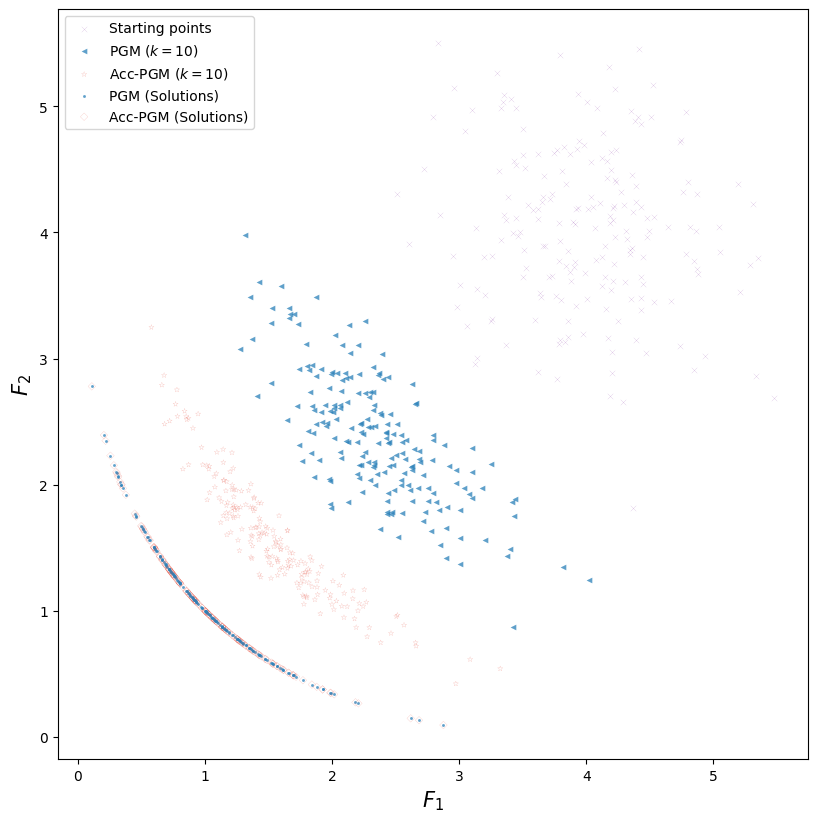

In [11]:
show_Pareto_front(
    problem_JOS1, results_JOS1, results_acc_JOS1, step=10, fname=f"JOS1_nf{n_features}.pdf"
)

### Inertial Accelerated Proximal Gradient Method

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

0it [00:00, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.09295868873596191s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 185 out of 200 | elapsed:    2.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.6s finished


0it [00:00, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

0it [00:00, ?it/s]

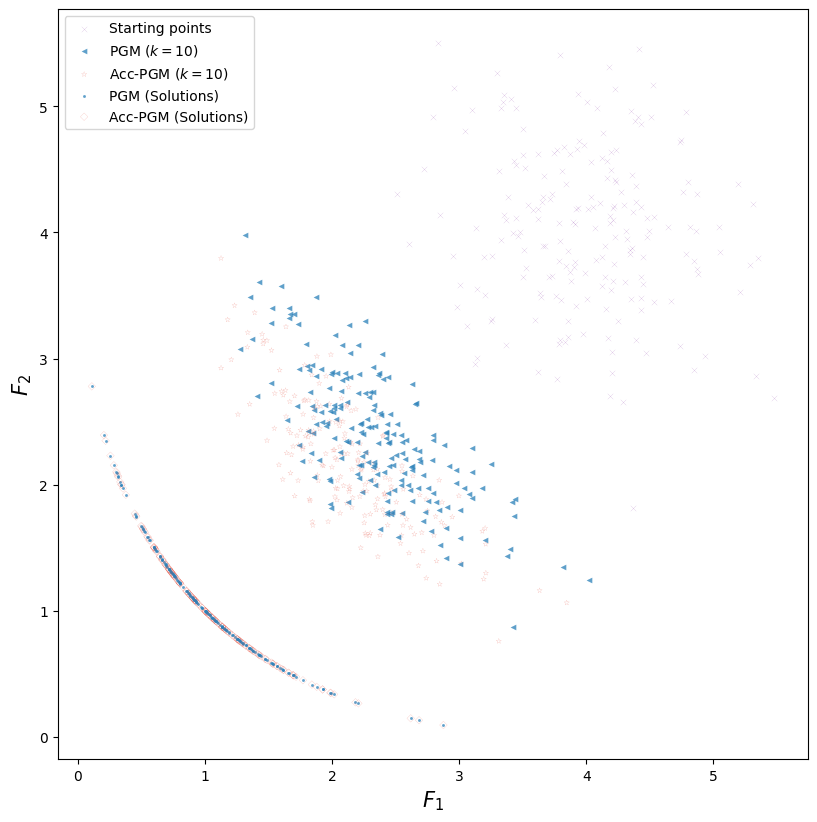

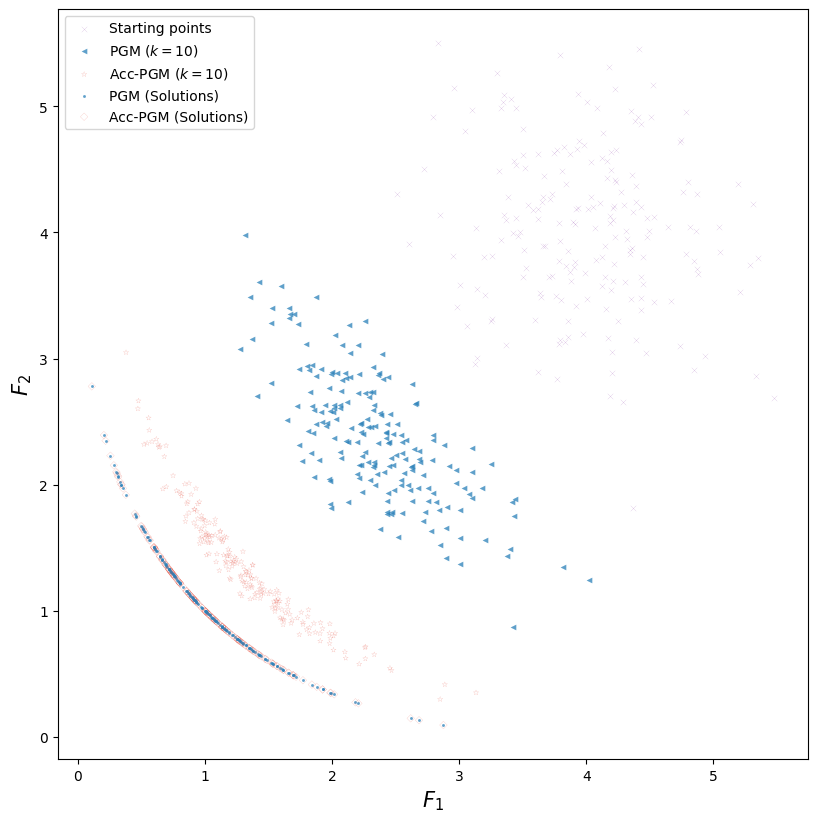

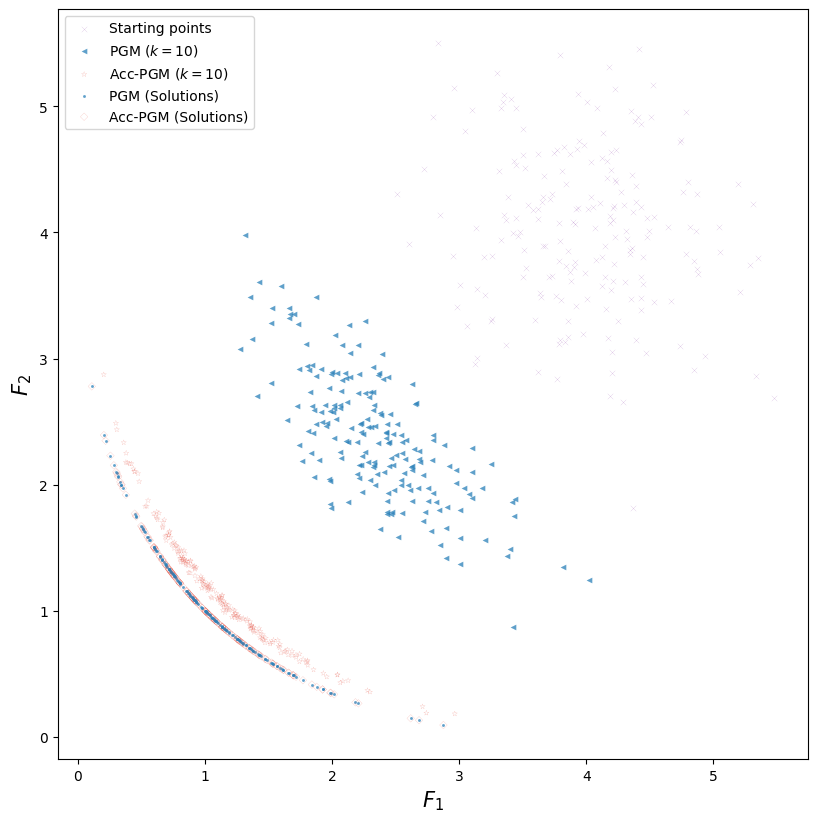

In [17]:
betas=[0.1,0.5, 0.9]
for beta in betas:
    alpha = round(2*beta / (1+beta), 3)
    results_inertial_JOS1 = run(problem_JOS1, start_points_JOS1, inertial=True, inertial_params=(alpha, beta))
    stats_JOS1[f"Inertial_PGM_al{alpha}_be{beta}"] =  get_stats(results_inertial_JOS1)
    show_Pareto_front(
    problem_JOS1, results_JOS1, results_inertial_JOS1, step=10, fname=f"JOS1_nf{n_features}_in_alpha{alpha}_beta{beta}.pdf"
)

In [16]:
pprint.pprint(stats_JOS1)

{'Acc-PGM': {'nit': {'max': 65, 'mean': 65.0, 'std': 0.0},
             'nit_internal': {'max': 542,
                              'mean': 422.31,
                              'std': 29.550869699553687}},
 'Inertial_PGM': {'nit': {'max': 50,
                          'mean': 49.015,
                          'std': 0.12155245781143219},
                  'nit_internal': {'max': 416,
                                   'mean': 327.515,
                                   'std': 26.57046809900044}},
 'Inertial_PGM_al0.182_be0.1': {'nit': {'max': 191,
                                        'mean': 188.11,
                                        'std': 1.0285426583277917},
                                'nit_internal': {'max': 1289,
                                                 'mean': 1155.01,
                                                 'std': 28.09643927617875}},
 'Inertial_PGM_al0.667_be0.5': {'nit': {'max': 49,
                                        'mean': 48.905,
          

In [ ]:
# plt.yscale("log")
# plt.xlabel(r"$k$", fontsize=15)
# plt.ylabel(r"$\|x^k - y^k\|_\infty$", fontsize=15)
# plt.plot(
#     results_JOS1[0].all_error_criteria, color="#2980b9", label="PGM", linestyle="dashed"
# )
# plt.plot(results_acc_JOS1[0].all_error_criteria, color="#e74c3c", label="Acc-PGM")
# plt.legend()
# plt.savefig(fig_path + "/JOS1_error_.pdf", bbox_inches="tight")

## JOS1 + $\ell_1$ penalty
Minimize
$$
F_1(x) = \frac{1}{n} \| x \|_2^2 + \frac{1}{n} \|x\|_1, \quad F_2(x) = \frac{1}{n} \| x - 2\|_2^2 + \frac{1}{2n} \|x - 1\|_1
$$
subject to $x \in \mathbf{R}^n$.

In [18]:
n_features = 50
problem_JOS1_L1 = JOS1(n_features=n_features, l1_ratios=(1 / n_features, 1 / n_features / 2), l1_shifts=[0, 1])
start_points_JOS1_L1 = generate_start_points(low=-2, high=4, n_features=n_features, n_samples = n_samples)

### Proximal Gradient Method

In [19]:
results_JOS1_L1 = run(problem_JOS1_L1, start_points_JOS1_L1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4

### Accelerated Proximal Gradient Method

In [20]:
results_acc_JOS1_L1 = run(problem_JOS1_L1, start_points_JOS1_L1, nesterov=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3

### Complexity

In [23]:
stats_JOS1_L1 = {
    "PGM": get_stats(results_JOS1_L1),
    "Acc-PGM": get_stats(results_acc_JOS1_L1),
}
pprint.pprint(stats_JOS1_L1)

{'Acc-PGM': {'nit': {'max': 187, 'mean': 161.175, 'std': 16.264205329495812},
             'nit_internal': {'max': 2187,
                              'mean': 1642.2,
                              'std': 261.87405369757425}},
 'PGM': {'nit': {'max': 228, 'mean': 219.3, 'std': 6.776429738438966},
         'nit_internal': {'max': 3350,
                          'mean': 2289.455,
                          'std': 345.5135279189514}}}


0it [00:00, ?it/s]

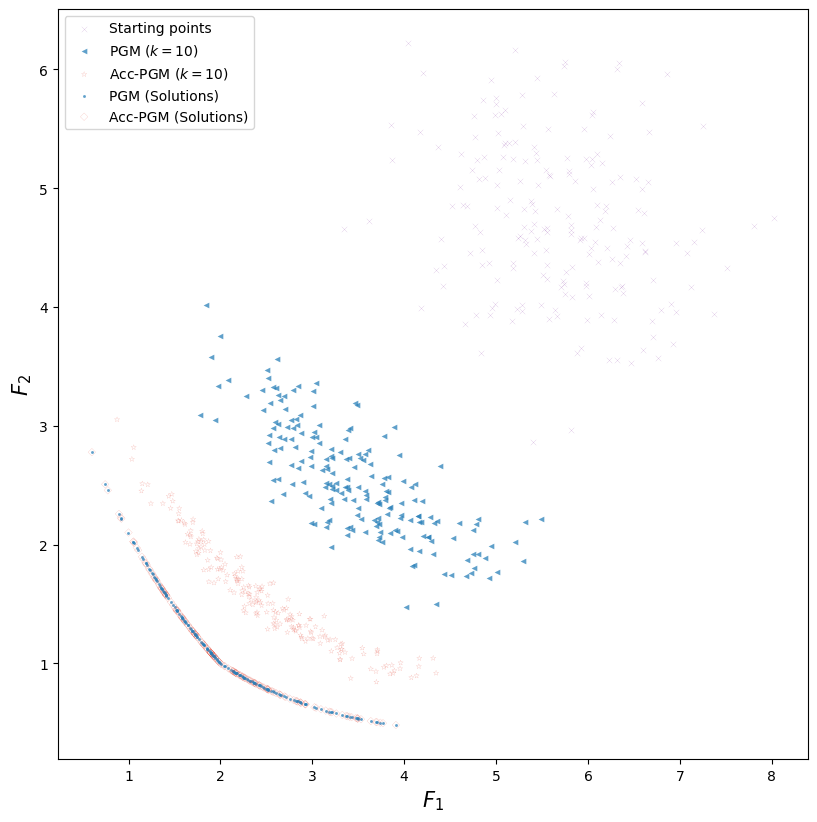

In [22]:
show_Pareto_front(
    problem_JOS1_L1, results_JOS1_L1, results_acc_JOS1_L1, step=10, fname=f"JOS1_L1_nf{n_features}.pdf"
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   48.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   54.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2

0it [00:00, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

0it [00:00, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2

0it [00:00, ?it/s]

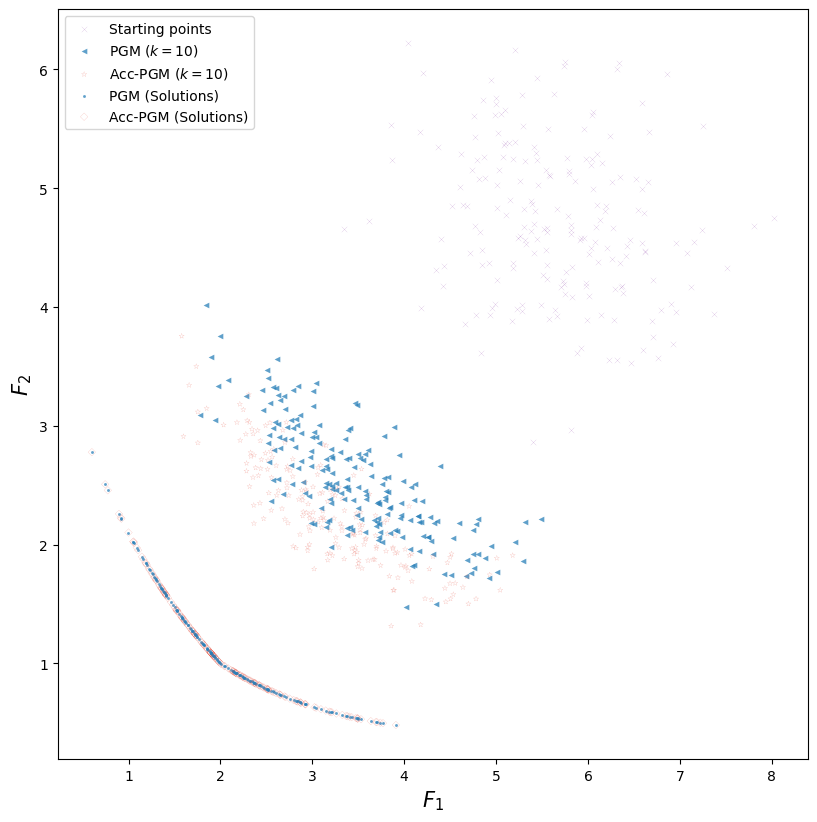

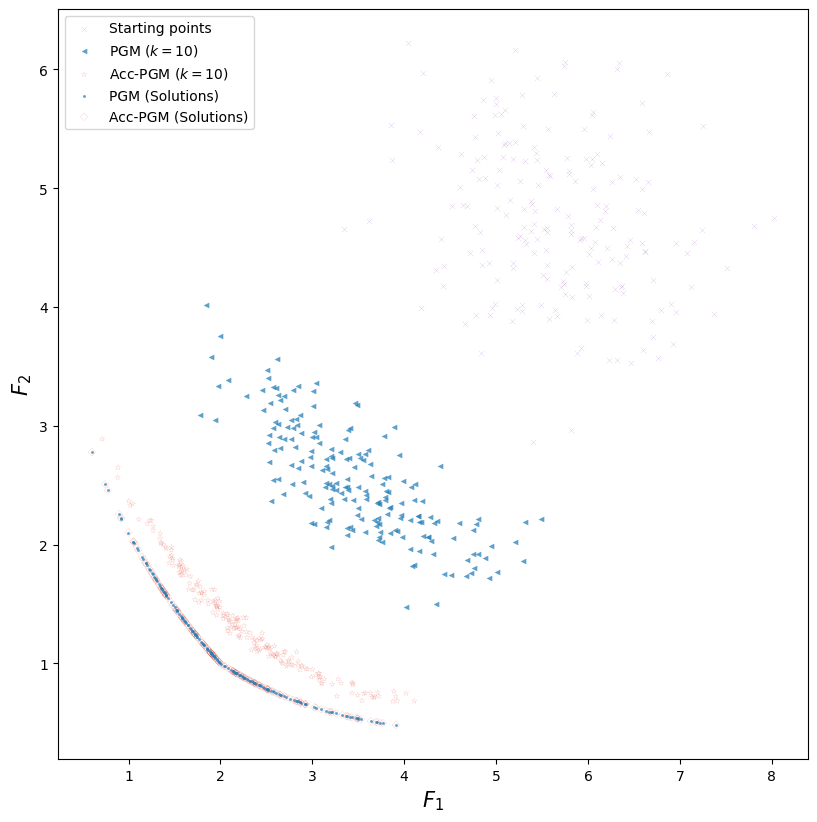

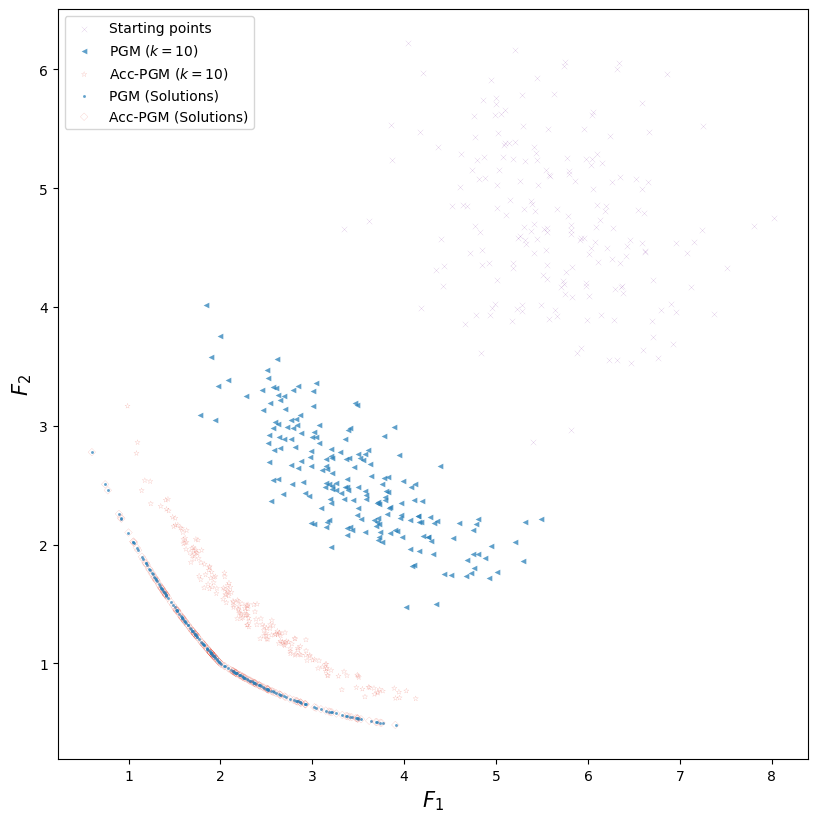

In [24]:
betas=[0.1,0.5, 0.9]
for beta in betas:
    alpha = round(2*beta / (1+beta), 3)
    results_inertial_JOS1_L1 = run(problem_JOS1_L1, start_points_JOS1_L1, inertial=True, inertial_params=(alpha, beta))
    stats_JOS1_L1[f"Inertial_PGM_al{alpha}_be{beta}"] =  get_stats(results_inertial_JOS1_L1)
    show_Pareto_front(problem_JOS1_L1, results_JOS1_L1, results_inertial_JOS1_L1, 
                      step=10, fname=f"JOS1_L1_nf{n_features}_in_alpha{alpha}_beta{beta}.pdf")

In [25]:
pprint.pprint(stats_JOS1_L1)

{'Acc-PGM': {'nit': {'max': 187, 'mean': 161.175, 'std': 16.264205329495812},
             'nit_internal': {'max': 2187,
                              'mean': 1642.2,
                              'std': 261.87405369757425}},
 'Inertial_PGM_al0.182_be0.1': {'nit': {'max': 185,
                                        'mean': 177.77,
                                        'std': 5.553116242255334},
                                'nit_internal': {'max': 2603,
                                                 'mean': 1863.66,
                                                 'std': 272.6508103784032}},
 'Inertial_PGM_al0.667_be0.5': {'nit': {'max': 56,
                                        'mean': 51.99,
                                        'std': 2.353699216127669},
                                'nit_internal': {'max': 747,
                                                 'mean': 545.8,
                                                 'std': 79.77192488588952}},
 'Inertial_PGM_al0.

In [ ]:
# plt.yscale("log")
# plt.xlabel(r"$k$", fontsize=15)
# plt.ylabel(r"$\|x^k - y^k\|_\infty$", fontsize=15)
# plt.plot(
#     results_JOS1_L1[0].all_error_criteria,
#     color="#2980b9",
#     label="PGM",
#     linestyle="dashed",
# )
# plt.plot(results_acc_JOS1_L1[0].all_error_criteria, color="#e74c3c", label="Acc-PGM")
# plt.legend()
# plt.savefig(fig_path + "/JOS1_L1_error.pdf", bbox_inches="tight")

## SD
Minimize
$$F_1(x) = 2 x_1 + \sqrt{2} x_2 + \sqrt{2} x_3 + x_4, \quad F_2(x) = \frac{2}{x_1} + \frac{2 \sqrt{2}}{x_2} + \frac{2 \sqrt{2}}{x_3} + \frac{2}{x_4}$$
subject to $(1, \sqrt{2}, \sqrt{2}, 1)^\top \le x \le (3, 3, 3, 3)^\top$.

In [26]:
low = [1, np.sqrt(2), np.sqrt(2), 1]
high = [3, 3, 3, 3]

problem_SD = SD()
start_points_SD = generate_start_points(
    low=low, high=high, n_features=problem_SD.n_features, n_samples = n_samples
)

### Proximal Gradient Method

In [27]:
results_SD = run(problem_SD, start_points_SD)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

### Accelerated Proximal Gradient Method

In [28]:
results_acc_SD = run(problem_SD, start_points_SD, nesterov=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

### Complexity

In [29]:
stats_SD = {"PGM": get_stats(results_SD), "Acc-PGM": get_stats(results_acc_SD)}
pprint.pprint(stats_SD)

{'Acc-PGM': {'nit': {'max': 62, 'mean': 32.435, 'std': 7.969678475321322},
             'nit_internal': {'max': 378,
                              'mean': 195.99,
                              'std': 48.72678832018379}},
 'PGM': {'nit': {'max': 86, 'mean': 35.91, 'std': 11.739331326783482},
         'nit_internal': {'max': 522,
                          'mean': 216.75,
                          'std': 71.33174258350905}}}


0it [00:00, ?it/s]

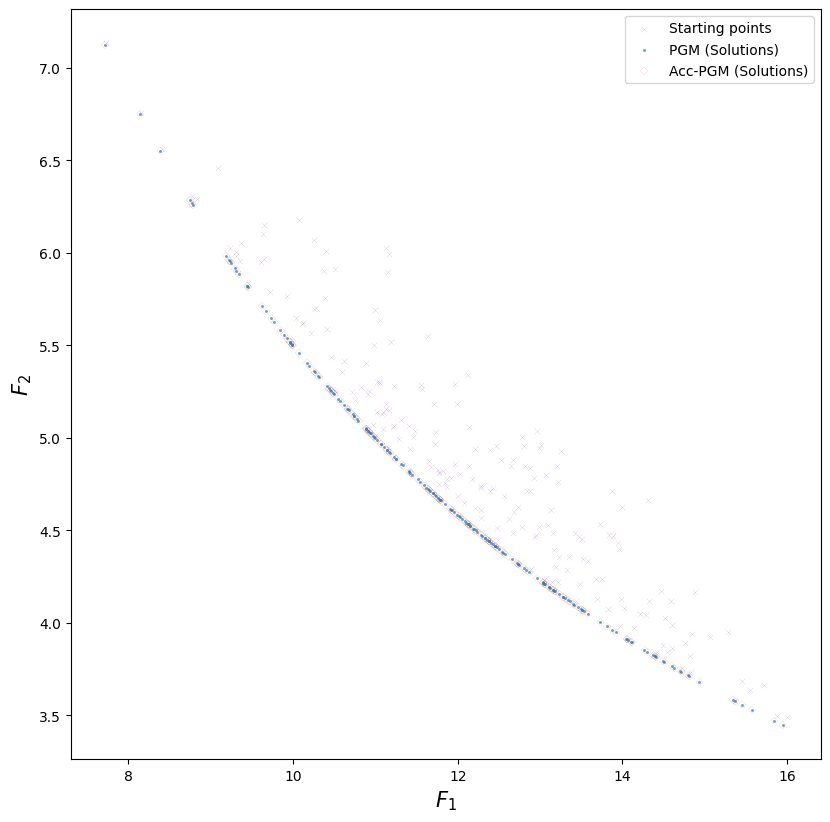

In [30]:
%matplotlib inline
show_Pareto_front(problem_SD, results_SD, results_acc_SD, fname="SD.pdf")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

0it [00:00, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

0it [00:00, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

0it [00:00, ?it/s]

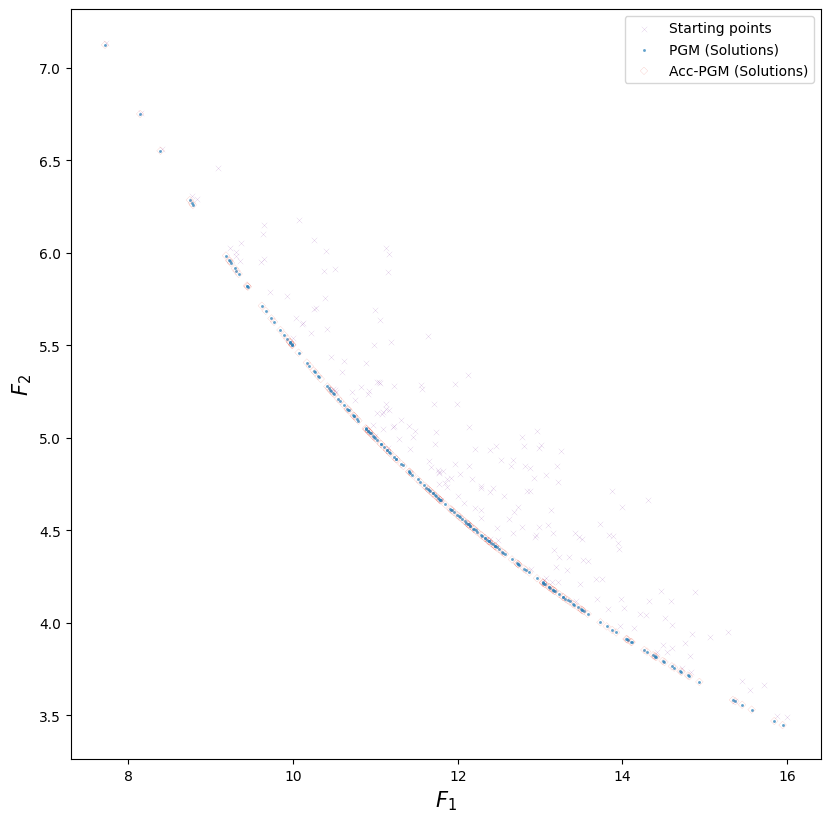

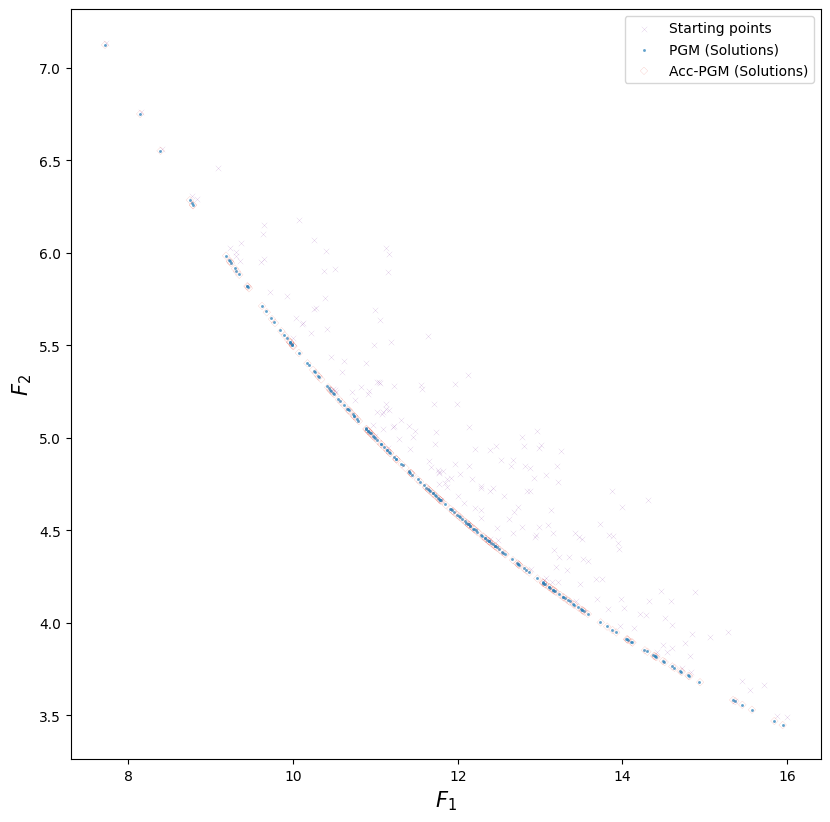

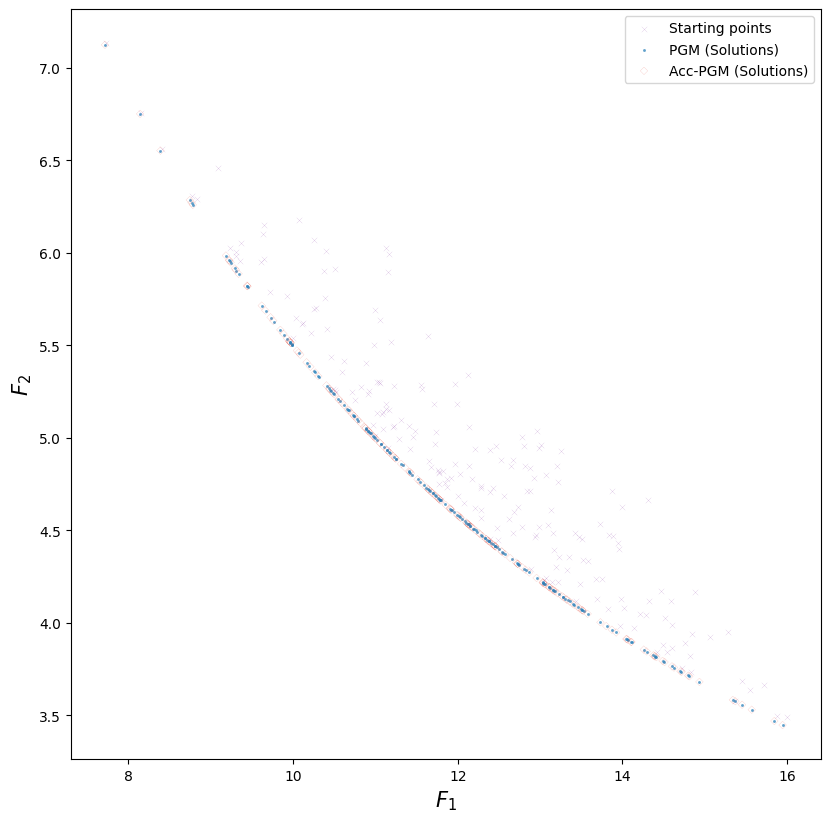

In [31]:
betas=[0.1,0.5, 0.9]
for beta in betas:
    alpha = round(2*beta / (1+beta), 3)
    results_inertial_SD = run(problem_SD, start_points_SD, inertial=True, inertial_params=(alpha, beta))
    stats_SD[f"Inertial_PGM_al{alpha}_be{beta}"] =  get_stats(results_inertial_SD)
    show_Pareto_front(problem_SD, results_SD, results_inertial_SD, fname=f"SD_IN_alpha{alpha}_beta{beta}.pdf")

In [32]:
pprint.pprint(stats_SD)

{'Acc-PGM': {'nit': {'max': 62, 'mean': 32.435, 'std': 7.969678475321322},
             'nit_internal': {'max': 378,
                              'mean': 195.99,
                              'std': 48.72678832018379}},
 'Inertial_PGM_al0.182_be0.1': {'nit': {'max': 68,
                                        'mean': 30.105,
                                        'std': 9.212164512208844},
                                'nit_internal': {'max': 414,
                                                 'mean': 183.03,
                                                 'std': 56.61341802081906}},
 'Inertial_PGM_al0.667_be0.5': {'nit': {'max': 48,
                                        'mean': 31.74,
                                        'std': 4.480223208725208},
                                'nit_internal': {'max': 306,
                                                 'mean': 194.82,
                                                 'std': 29.460610991627448}},
 'Inertial_PGM_al0.947_be

In [ ]:
# plt.yscale("log")
# plt.xlabel(r"$k$", fontsize=15)
# plt.ylabel(r"$\|x^k - y^k\|_\infty$", fontsize=15)
# plt.plot(
#     results_SD[0].all_error_criteria, color="#2980b9", label="PGM", linestyle="dashed"
# )
# plt.plot(results_acc_SD[0].all_error_criteria, color="#e74c3c", label="Acc-PGM")
# plt.legend()
# plt.savefig(fig_path + "/SD_error.pdf", bbox_inches="tight")

## FDS
Minimize
$$F_1(x) = \frac{1}{n^2} \sum_{i = 1}^n i (x_i - i)^4, \quad F_2(x) = \exp \left( \sum_{i = 1}^n \frac{x_i}{n} \right) + \|x\|_2^2, \quad F_3(x) = \frac{1}{n(n + 1)} \sum_{i = 1}^n i (n - i + 1) \exp (- x_i)$$
subject to $x \in \mathbf{R}^n$.

In [36]:
n_features = 10
n_samples = 50
problem_FDS = FDS(n_features=n_features)
start_points_FDS = generate_start_points(low=-2, high=2, n_features=n_features, n_samples=n_samples)

### Proximal Gradient Method

In [34]:
results_FDS = run(problem_FDS, start_points_FDS)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 2497.2min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 2501.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 2504.6min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 2508.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 2512.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 2515.2min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 2519.0min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 2523.2min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 2527.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 2535.9min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 2539.8min
[Parallel(n_jobs=-1)]: Done 184 ta

### Accelerated Proximal Gradient Method

In [37]:
results_acc_FDS = run(problem_FDS, start_points_FDS, nesterov=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  4.1min remaining:   53.3s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  4.5min remaining:   17.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.7min finished


### Complexity

In [38]:
stats_FDS = {"PGM": get_stats(results_FDS), "Acc-PGM": get_stats(results_acc_FDS)}
pprint.pprint(stats_FDS)

{'Acc-PGM': {'nit': {'max': 370, 'mean': 231.3, 'std': 57.474951065659894},
             'nit_internal': {'max': 14672,
                              'mean': 9155.7,
                              'std': 2297.3288423732465}},
 'PGM': {'nit': {'max': 2548, 'mean': 618.595, 'std': 552.0235782781384},
         'nit_internal': {'max': 101158,
                          'mean': 24659.525,
                          'std': 21287.453354485006}}}


0it [00:00, ?it/s]

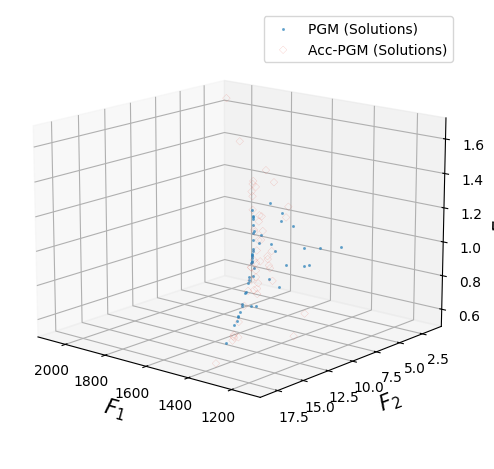

In [39]:
%matplotlib inline
show_Pareto_front(problem_FDS, results_FDS, results_acc_FDS, fname=f"FDS_nf{n_features}.pdf")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed: 14.5min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed: 21.3min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 31.3min finished


0it [00:00, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  9.6min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed: 10.9min remaining:   41.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 11.5min finished


0it [00:00, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  3.8min remaining:   50.0s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  4.3min remaining:   16.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.4min finished


0it [00:00, ?it/s]

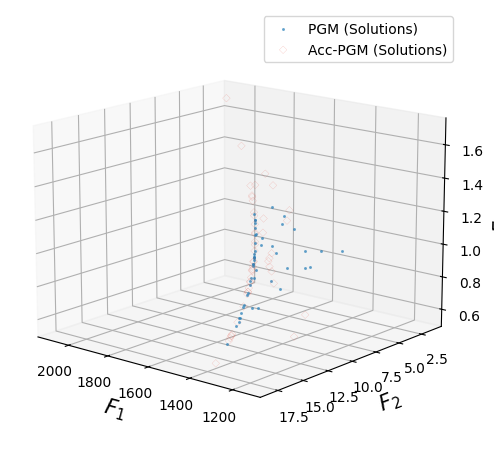

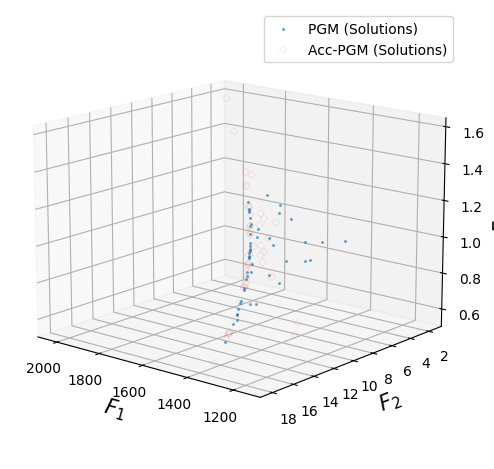

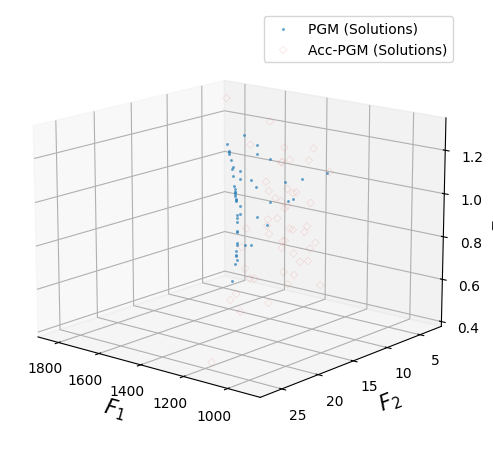

In [40]:
betas=[0.1,0.5, 0.9]
for beta in betas:
    alpha = round(2*beta / (1+beta), 3)
    results_inertial_FDS = run(problem_FDS, start_points_FDS, inertial=True, inertial_params=(alpha, beta))
    stats_FDS[f"Inertial_PGM_al{alpha}_be{beta}"] =  get_stats(results_inertial_FDS)
    show_Pareto_front(problem_FDS, results_FDS, results_inertial_FDS, step=10, fname=f"FDS_nf{n_features}_in_alpha{alpha}_beta{beta}.pdf")

In [41]:
pprint.pprint(stats_FDS)

{'Acc-PGM': {'nit': {'max': 370, 'mean': 231.3, 'std': 57.474951065659894},
             'nit_internal': {'max': 14672,
                              'mean': 9155.7,
                              'std': 2297.3288423732465}},
 'Inertial_PGM_al0.182_be0.1': {'nit': {'max': 13204,
                                        'mean': 1264.32,
                                        'std': 2163.551667420956},
                                'nit_internal': {'max': 492461,
                                                 'mean': 48894.5,
                                                 'std': 81007.07169852518}},
 'Inertial_PGM_al0.667_be0.5': {'nit': {'max': 3209,
                                        'mean': 581.78,
                                        'std': 774.624923172499},
                                'nit_internal': {'max': 119556,
                                                 'mean': 22881.28,
                                                 'std': 29486.418036811458}},
 'Iner

In [ ]:
# plt.yscale("log")
# plt.xlabel(r"$k$", fontsize=15)
# plt.ylabel(r"$\|x^k - y^k\|_\infty$", fontsize=15)
# plt.plot(
#     results_FDS[0].allerrs, color="#2980b9", label="PGM", linestyle="dashed"
# )
# plt.plot(results_acc_FDS[0].allerrs, color="#e74c3c", label="Acc-PGM")
# plt.legend()
# plt.savefig(fig_path + "/FDS_error.pdf", bbox_inches="tight")

## FDS CONSTRAINED
Minimize
$$F_1(x) = \frac{1}{n^2} \sum_{i = 1}^n i (x_i - i)^4, \quad F_2(x) = \exp \left( \sum_{i = 1}^n \frac{x_i}{n} \right) + \|x\|_2^2, \quad F_3(x) = \frac{1}{n(n + 1)} \sum_{i = 1}^n i (n - i + 1) \exp (- x_i)$$
subject to $x \in \mathbf{R}_+^n$.

In [ ]:
n_features = 10
problem_FDS_CONSTRAINED = FDS_CONSTRAINED(n_features=n_features)
start_points_FDS_CONSTRAINED = generate_start_points(low=0, high=2, n_features=n_features)

In [ ]:
results_FDS_CONSTRAINED = run(problem_FDS_CONSTRAINED, start_points_FDS_CONSTRAINED)

In [ ]:
results_acc_FDS_CONSTRAINED = run(
    problem_FDS_CONSTRAINED, start_points_FDS_CONSTRAINED, nesterov=True
)

In [ ]:
stats_FDS_CONSTRAINED = {
    "PGM": get_stats(results_FDS_CONSTRAINED),
    "Acc-PGM": get_stats(results_acc_FDS_CONSTRAINED),
}
pprint.pprint(stats_FDS_CONSTRAINED)

In [ ]:
%matplotlib inline
show_Pareto_front(
    problem_FDS_CONSTRAINED,
    results_FDS_CONSTRAINED,
    results_acc_FDS_CONSTRAINED,
    fname="FDS_CONSTRAINED.pdf",
)

In [ ]:
betas=[0.1,0.5, 0.9]
for beta in betas:
    alpha = round(2*beta / (1+beta), 3)
    results_inertial_FDS_constrained = run(problem_FDS_constrained, start_points_FDS_constrained, inertial=True, inertial_params=(alpha, beta))
    stats_FDS_constrained[f"Inertial_PGM_al{alpha}_be{beta}"] =  get_stats(results_inertial_FDS_constrained)
    show_Pareto_front(problem_FDS_constrained, results_FDS_constrained, results_inertial_FDS_constrained, step=10, fname=f"FDS_constrained_nf{n_features}_in_alpha{alpha}_beta{beta}.pdf")

In [ ]:
# plt.yscale("log")
# plt.xlabel(r"$k$", fontsize=15)
# plt.ylabel(r"$\|x^k - y^k\|_\infty$", fontsize=15)
# plt.plot(
#     results_FDS_CONSTRAINED[0].all_error_criteria,
#     color="#2980b9",
#     label="PGM",
#     linestyle="dashed",
# )
# plt.plot(
#     results_acc_FDS_CONSTRAINED[0].all_error_criteria, color="#e74c3c", label="Acc-PGM"
# )
# plt.legend()
# plt.savefig(fig_path + "/FDS_CONSTRAINED_error.pdf", bbox_inches="tight")

## TRIDIA
$$
        \begin{gathered}
        f_1(x) = (2 x_1 - 1)^2,
        f_2(x) = 2 (2 x_1 - x_2)^2,
        f_3(x) = 3 (2 x_2 - x_3)^2.
        \end{gathered}
$$


In [ ]:
n_features = 3
problem_TRIDIA = TRIDIA()
start_points_TRIDIA = generate_start_points(low=-1, high=1, n_features=n_features, n_samples=n_samples)

In [ ]:
results_TRIDIA = run(problem_TRIDIA, start_points_TRIDIA)

In [ ]:
results_acc_TRIDIA = run(problem_TRIDIA, start_points_TRIDIA, nesterov=True)

In [ ]:
stats_TRIDIA = {
    "PGM": get_stats(results_TRIDIA),
    "Acc-PGM": get_stats(results_acc_TRIDIA),
}
pprint.pprint(stats_TRIDIA)

In [ ]:
%matplotlib inline
show_Pareto_front(
    problem_TRIDIA,
    results_TRIDIA,
    results_acc_TRIDIA,
    step = 5,
    fname="TRIDIA.pdf",
)

## ZDT1
$$
        \begin{gathered}
        f_1(x) = x_1, \\
        f_2(x) = h(x) \left( 1 - \sqrt{\frac{x_1}{h(x)}} \right),
        \end{gathered}
$$ 

where 
$h(x) = 1 + \frac{9}{n - 1} \sum_{i=2}^n x_i.$

In [ ]:
n_features = 50
problem_ZDT1 = ZDT1(n_features=n_features)
start_points_ZDT1 = generate_start_points(low=0, high=0.01, n_features=n_features, n_samples=n_samples)

In [ ]:
results_ZDT1 = run(problem_ZDT1, start_points_ZDT1)

In [ ]:
results_acc_ZDT1 = run(problem_ZDT1, start_points_ZDT1, nesterov=True)

In [ ]:
stats_ZDT1 = {
    "PGM": get_stats(results_ZDT1),
    "Acc-PGM": get_stats(results_acc_ZDT1),
}
pprint.pprint(stats_ZDT1)

In [ ]:
%matplotlib inline
show_Pareto_front(
    problem_ZDT1,
    results_ZDT1,
    results_acc_ZDT1,
    step = 5,
    fname="ZDT1_nf50.pdf",
)